# **Prompt Based Generative cloth design editing with CLIPSEG + Stable Diffusion Model**

In [ ]:
import os
from google.colab import userdata

**This Notebook demonstartes the Use of Fine models like Stable Diffusion, Clip-seg (CLIP + Sam : prompt based segmentaion) to genrate a prompt based cloth ediiting functionality**

In [ ]:
!nvidia-smi

Wed Apr 23 04:10:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
new_directory = '/content/drive/MyDrive/Gen_Ai_project'

# Change the current working directory
os.chdir(new_directory)

# Verify the change by printing the current working directory
HOME = os.getcwd()
print("Current working directory:", HOME)

Current working directory: /content/drive/MyDrive/Gen_Ai_project


In [ ]:
### General Libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 58.1 MB/s eta 0:00:00


In [ ]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys



In [ ]:
# Install Clip from OpenAI ## MIT Licence
!pip install -q git+https://github.com/openai/CLIP.git

# Install ClipSeg Repo ## MIT Licence
!git clone https://github.com/timojl/clipseg

  Preparing metadata (setup.py) ... done
Cloning into 'clipseg'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 232 (delta 72), reused 58 (delta 58), pack-reused 147 (from 1)
Receiving objects: 100% (232/232), 1.40 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
%cd clipseg/

/content/drive/MyDrive/Gen_Ai_project/clipseg


In [ ]:
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip

--2025-04-23 04:19:28--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [      <=>           ]   9.68M  9.16MB/s    in 1.1s    

2025-04-23 04:19:30 (9.16 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [ ]:
# Import Clip and ClipSeg model
import torch
import clip
from models.clipseg import CLIPDensePredT

# load clipseg model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

# non-strict mode: decoder weights only (no CLIP weights)
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);

100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 74.4MiB/s]


Source image size: (1920, 2844)
Target image size: (512, 512)


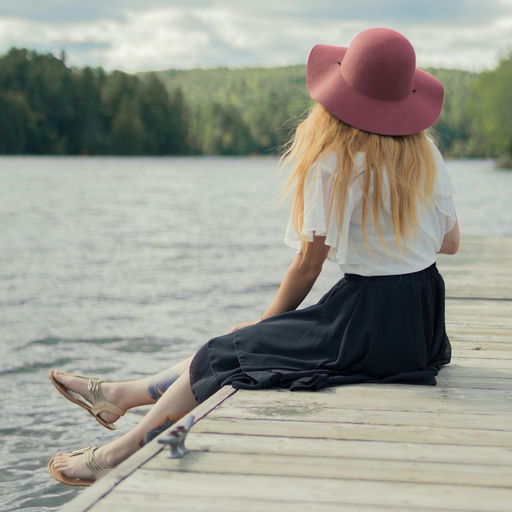

In [ ]:
target_width, target_height = 512,512
source_image = Image.open('/content/drive/MyDrive/Gen_Ai_project/mix909-AsJirOOLN_s-unsplash.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

### Setup transformations to be applied to the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_image = transform(source_image).unsqueeze(0)

display(source_image)

* **Convert the Image to Tensor for Segmentaion**
* **Convert it to PIL to pass to the stable diffusion model**

In [ ]:
def show_pred(input_image_path,input_string):


    target_width, target_height = 512,512
    source_image = Image.open(input_image_path)

    width, height = source_image.size
    print(f"Source image size: {source_image.size}")

    source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)
    source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
    print(f"Target image size: {source_image.size}")

    ### Setup transformations to be applied to the image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    tensor_image = transform(source_image).unsqueeze(0)

    if not isinstance(input_string, str):
        raise TypeError("Input must be a string.")

    # Process the string (example)
    print("Processing string:", input_string)

    prompts = []
    prompts.append(input_string)


    # Use ClipSeg to identify elements in picture
    with torch.no_grad():
        preds = model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]


    # To plot the segmented Mask

    # _, ax = plt.subplots(1,len(prompts) + 1, figsize=(15, 4))
    # [a.axis('off') for a in ax.flatten()]
    # ax[0].imshow(source_image)
    # [ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
    # [ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];
    # plt.show()

    processed_mask = torch.special.ndtr(preds[0][0])

    stable_diffusion_mask = transforms.ToPILImage()(processed_mask)

    return source_image, stable_diffusion_mask


Please enter a string: a black skirt
Source image size: (1920, 2844)
Target image size: (512, 512)
Processing string: a black skirt


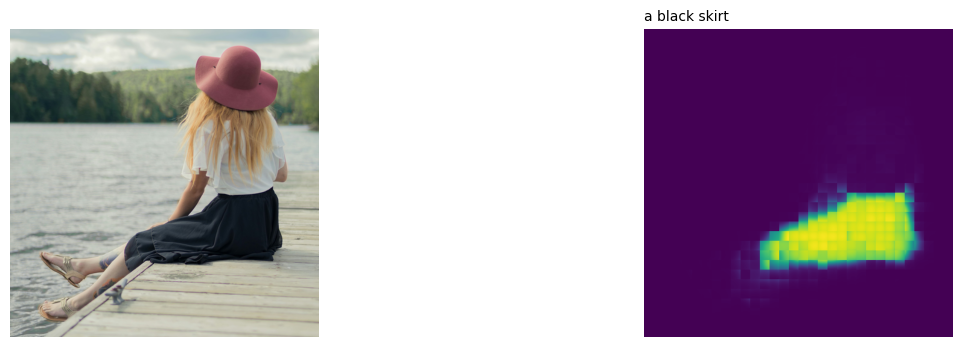

In [ ]:
user_input = input("Please enter a string: ")
stable_diffusion_mask = show_pred('/content/drive/MyDrive/Gen_Ai_project/mix909-AsJirOOLN_s-unsplash.jpg',user_input)


**Load Stable Diffusion Model and the Scheduler**

In [ ]:
### Import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transf

**Function to Run the Stable diffusion In the Inpainting mode**

In [ ]:
def stable_diffusion_inpainting(num_images_per_prompt,inpainting_prompts,source_image,stable_diffusion_mask):

  generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
  encoded_images = []
  for i in range(num_images_per_prompt):
          image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
          encoded_images.append(image)
  return encoded_images

**Function to Display the Results**

In [ ]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

# **Putting All the Pieces Together**

Please enter a string: a black skirt
Source image size: (1920, 2844)
Target image size: (512, 512)
Processing string: a black skirt
Please enter a int , for number of input inpainting prompts you want to give: 4
4
Please enter a string, what design you want , ex:a skirt full of text:  white circles
Please enter a string, what design you want , ex:a skirt full of text:  water droplets
Please enter a string, what design you want , ex:a skirt full of text:  zebra pattern
Please enter a string, what design you want , ex:a skirt full of text:  flower pattern
['white circles', 'water droplets', 'zebra pattern', 'flower pattern']


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

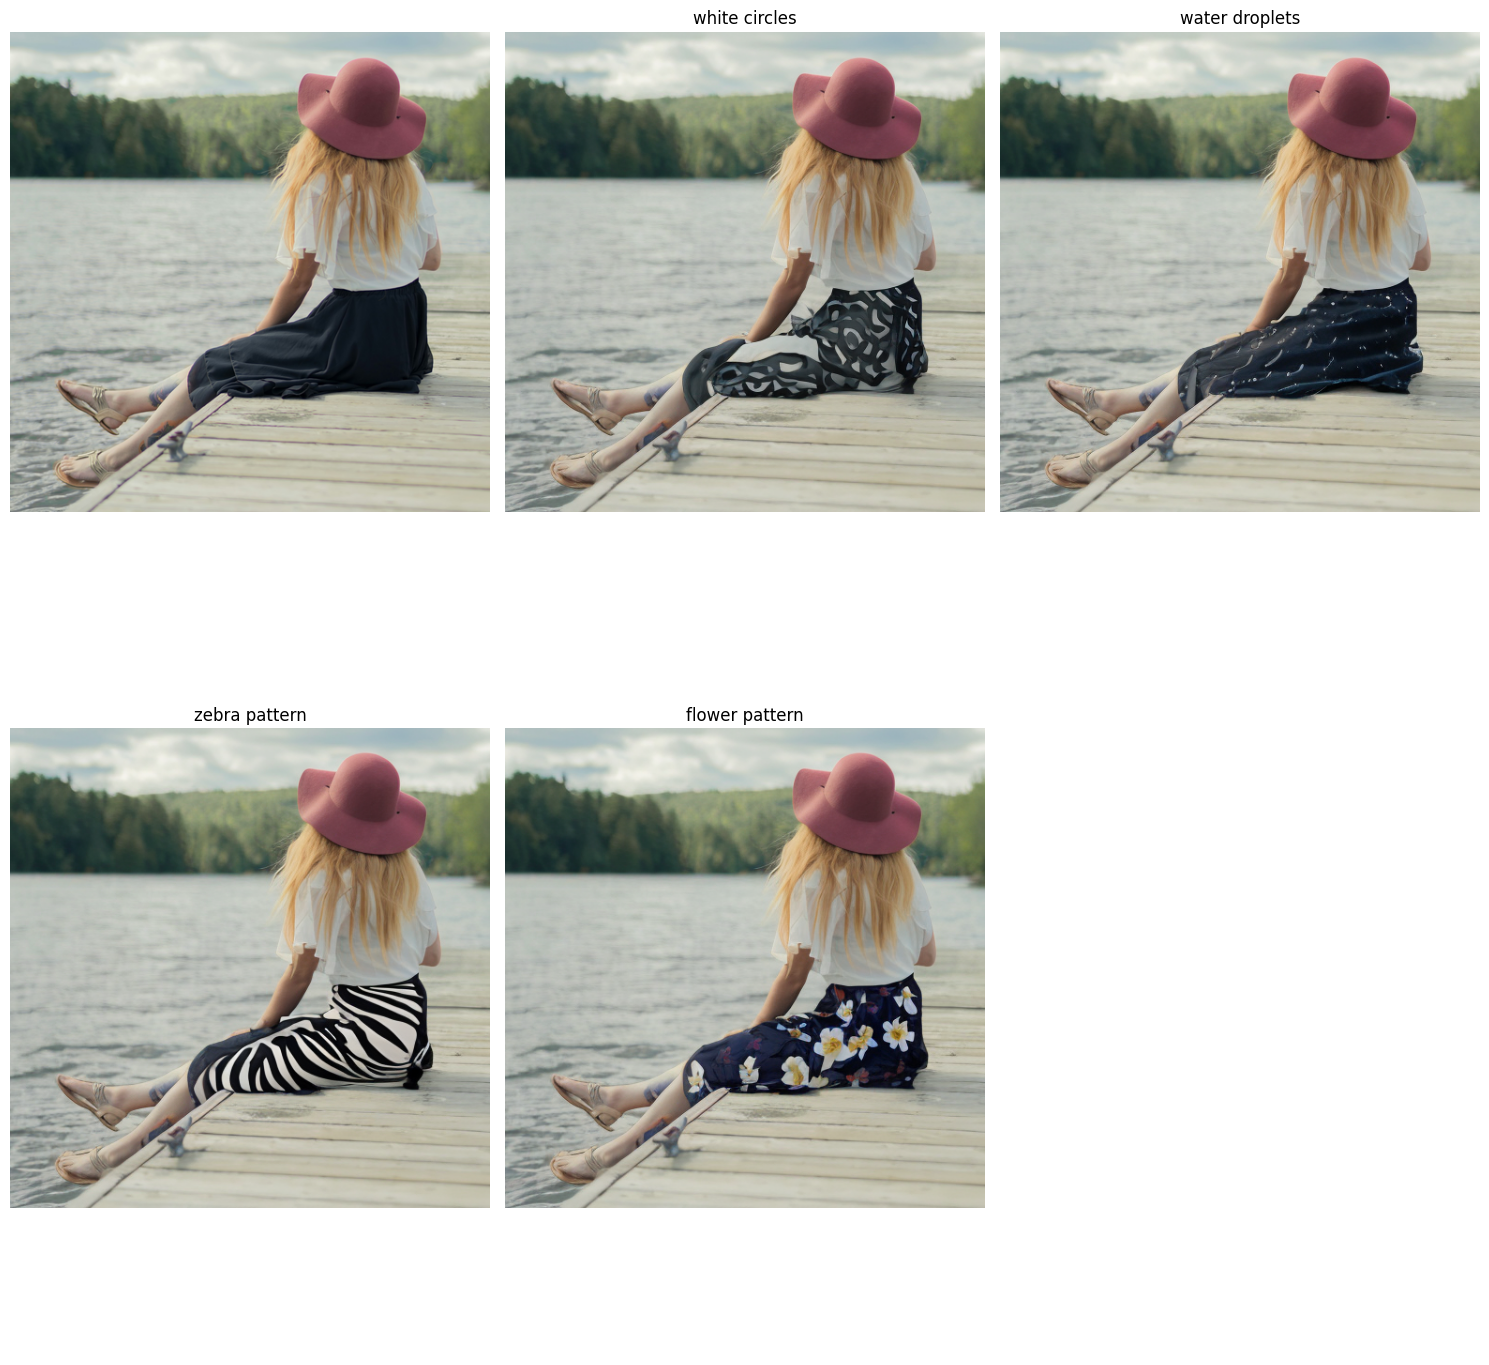

In [ ]:
user_input = input("Please enter a string: ")
source_image, stable_diffusion_mask = show_pred('/content/drive/MyDrive/Gen_Ai_project/mix909-AsJirOOLN_s-unsplash.jpg',user_input)
num_images_per_prompt = input("Please enter a int , for number of input inpainting prompts you want to give: ")
inpainting_prompts = []
print(num_images_per_prompt)

for i in range(int(num_images_per_prompt)):
  prompts_input = input("Please enter a string, what design you want , ex:a skirt full of text:  ")
  inpainting_prompts.append(prompts_input)




print(inpainting_prompts)
encoded_images = stable_diffusion_inpainting(int(num_images_per_prompt),inpainting_prompts,source_image,stable_diffusion_mask)
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)





Please enter a string: white shirt
Source image size: (4000, 6000)
Target image size: (512, 512)
Processing string: white shirt
Please enter a int , for number of input inpainting prompts you want to give: 4
4
Please enter a string, what design you want , ex:a skirt full of text:  shirt full of text
Please enter a string, what design you want , ex:a skirt full of text:  zebra pattern
Please enter a string, what design you want , ex:a skirt full of text:  flower pattern
Please enter a string, what design you want , ex:a skirt full of text:  black circles
['shirt full of text', 'zebra pattern', 'flower pattern', 'black circles']


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

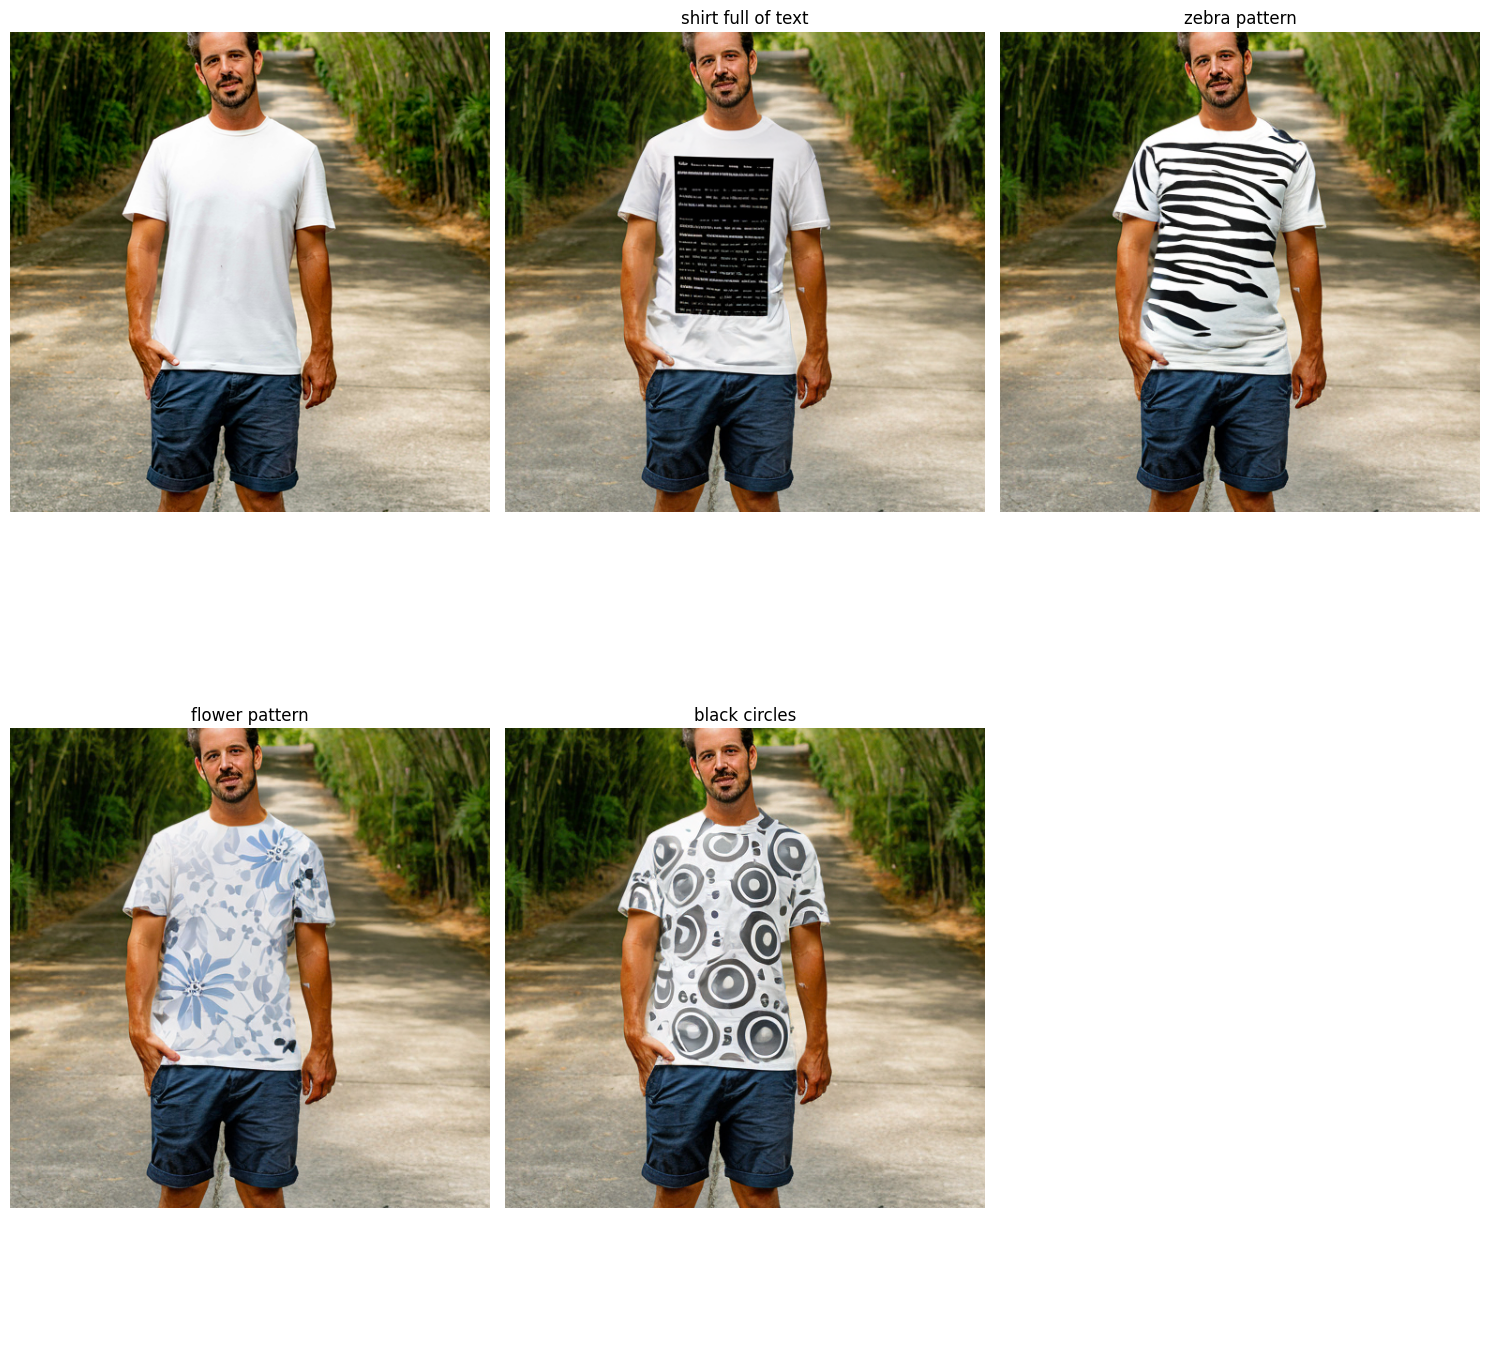

In [ ]:
user_input = input("Please enter a string: ")
source_image, stable_diffusion_mask = show_pred('/content/drive/MyDrive/Gen_Ai_project/antonio-araujo-fKASD_Qoois-unsplash.jpg\',user_input)
num_images_per_prompt = input("Please enter a int , for number of input inpainting prompts you want to give: ")
inpainting_prompts = []
print(num_images_per_prompt)

for i in range(int(num_images_per_prompt)):
  prompts_input = input("Please enter a string, what design you want , ex:a skirt full of text:  ")
  inpainting_prompts.append(prompts_input)




print(inpainting_prompts)
encoded_images = stable_diffusion_inpainting(int(num_images_per_prompt),inpainting_prompts,source_image,stable_diffusion_mask)
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

